# Estimation of regulatory influence between topics

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Absolute or relative path to the folder containing your scripts
pipeline_folder = "/home/l495i/GBM_analysis/"

# Add the folder to Python's module search path
if pipeline_folder not in sys.path:
    sys.path.append(pipeline_folder)

In [2]:
from python_scripts.topic_regulation import (
        get_activity_score,
        scale_gex_acc_topics,
        compute_topic_regulation_potential,
        scale_topic_regulation_target_topic,
        get_tf_topic_regulation,
        get_net_regulatory_interactions,
        compute_state_level_regulation
    )

### Load required inputs

In [3]:
#Load average accessibility of TFs within topics
acc = pd.read_csv("data/gene_score_by_selected_topics_scaled_allTFs.csv", sep=",") #replace with avg acc unscaled
acc.index = acc["Unnamed: 0"]
del acc["Unnamed: 0"] #Dataframe of size TFs x Topics

#Load average expression of TFs within topics
gex = pd.read_csv("data/gene_exp_by_selected_topics_scaled_allTFs.csv", sep=",") #replace with avg exp unscaled
gex.index = gex["Unnamed: 0"]
del gex["Unnamed: 0"]  #Dataframe of size TFs x Topics

#Load TF activity per topic
activators = pd.read_csv("data/topic_tf_activator_true_exp_05_03_raw.tsv", sep=",")
activators.index = activators["Unnamed: 0"]
del activators["Unnamed: 0"]
activators = activators.transpose() #Dataframe of size TFs x Topics

#Load activator regulons. Must be a numpy matrix of the size Topics x TFs x Genes. 
regulons_act= np.load("data/grn_atac_activator_9_11_001.npy")

#Load repressor regulons. Must be a numpy matrix of the size Topics x TFs x Genes.
regulons_rep= np.load("data/grn_repressor_finetuned_05_05_25.npy")


#List of genes scDORI was trained on. Must be in same order as in regulons
genes = pd.read_csv("data/topic_gene_sel.csv",sep=",")
genes = list(genes["Unnamed: 0"])

In [4]:
#List of selected topics to analyze
#Recommended: Include reference topics (TME) to avoid overestimation of TF activity when scaling across topics
topics_activity = [37,24,49,41,36,34,2,25,29,7,9,44,20,33,19,12,11,39,31,23,40,3]

#Specify TFs to exclude due to low/scattered expression in dataset. Recommended to avoid overestimation of TF activity when scaling across topics.
low_exp_TFs= ['ASCL2','BATF','EHF','EOMES','ERG','FOXB1','FOXC1','GATA3','GATA4','GFI1','GRHL2','HEYL','HHEX','HLX','IKZF3','IRF4','LYL1','NR1I2','PAX2','PAX5','PGR','POU2F3','POU5F1','PRRX2','RUNX3','TAL1','TBX18','TBX21','TBX3','TWIST2','VDR','FLI1','IKZF1','SOX18']

#Compute TF activity scores in each topic, considering relative activity to other TFs in topic and specificity of TF activity across topics.
activity = get_activity_score(activators, topics_activity, low_exp_TFs)
activity=activity.fillna(0)

#If only a subset of TFs are to be analyzed, specify here.
TFs = list(activators.index) 

#List of topics to perform topic regulation analysis on
topics = [37,24,41,49,36,34,2,25,29,7,9,44,20,33,19,12,11]

#Rescale gene expression and accessibility only considering specified topics
gex, acc = scale_gex_acc_topics(gex, acc, topics, TFs)

## Topic Activation Potential (TAP)

In [5]:
#Compute Topic Activation Potential (TAP) between every pair of topics
#TAP, tf_tr_act_links, background_TAP = compute_topic_regulation_potential(topics, activity, gex, acc, regulons_act, regulation="activation", compute_significance=True)
TAP, tf_tr_act_links, _ = compute_topic_regulation_potential(topics, activity, gex, acc, regulons_act, genes,low_exp_TFs=low_exp_TFs, regulation="activation", compute_significance=False)

TAP, col_scaling_vals = scale_topic_regulation_target_topic(TAP, scaling = "posCtrl", specificCtrl=[(37,TAP[37].loc[24])], return_scaling_vals = True)

100%|██████████| 17/17 [00:01<00:00, 15.65it/s]


[Text(0.5, 23.52222222222222, 'Target topic'),
 Text(50.722222222222214, 0.5, 'Source topic'),
 Text(0.5, 1.0, 'Topic Activation Potential (TAP)')]

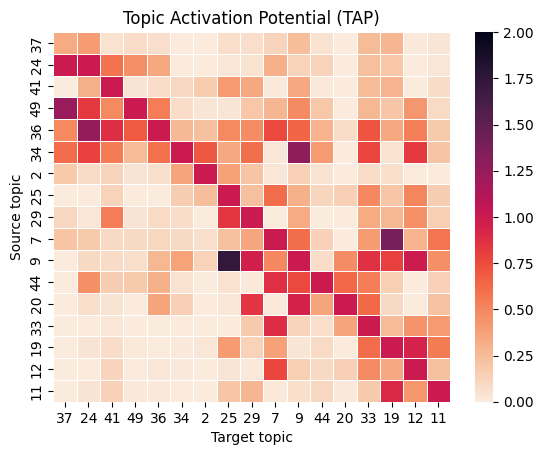

In [6]:
f=sns.heatmap(TAP,cmap=sns.color_palette("rocket_r", as_cmap=True),linewidths=0.5,vmax=2)
f.set(xlabel='Target topic', ylabel='Source topic', title="Topic Activation Potential (TAP)")

In [7]:
#Get TFs driving each topic's activation.
tf_TAP = get_tf_topic_regulation(tf_tr_act_links, topics, scale_by_topic=True)
tf_TAP #Dataframe showing the activating effect of TFs in each source topic (rows) towards TRs in alternate topics (columns)

,Source_topic,37,24,41,49,36,34,2,25,29,7,9,44,20,33,19,12,11,Total_effect
NFIA,37,0.0,0.08271,0.0,0.0,0.322747,0.0,0.0,0.167507,0.068428,0.063909,0.482948,0.170713,0.0,0.250644,0.0,0.0,0.049799,1.659406
SOX11,37,0.0,0.241267,0.138936,0.126115,0.0,0.0,0.0,0.0,0.0,0.149084,0.139142,0.0,0.0,0.020134,0.0,0.0,0.0,0.814678
PROX1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263306,0.0,0.0,0.160052,0.127085,0.0,0.0,0.550443
NPAS2,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344499,0.190772,0.0,0.0,0.535271
POU2F2,37,0.340721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052222,0.041455,0.0,0.0,0.434398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ETS1,11,0.003274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137158,0.140432
HSF1,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039099,0.039099
NKX6-2,11,0.0,0.030589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030589
SMAD3,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013854,0.0,0.0,0.013854


## Topic repression score (TRS)

In [8]:
#Compute Topic Repression Score (TRS) between every pair of topics
TRS, tf_tr_rep_links, background_TRS = compute_topic_regulation_potential(topics, activity, gex, acc, regulons_rep, genes, low_exp_TFs=low_exp_TFs,regulation="repression",compute_significance=False)
TRS = scale_topic_regulation_target_topic(TRS, specificCtrl=col_scaling_vals, return_scaling_vals = False)

100%|██████████| 17/17 [00:01<00:00, 16.85it/s]


[Text(0.5, 23.52222222222222, 'Target topic'),
 Text(50.722222222222214, 0.5, 'Source topic'),
 Text(0.5, 1.0, 'Topic Repression Score (TRS)')]

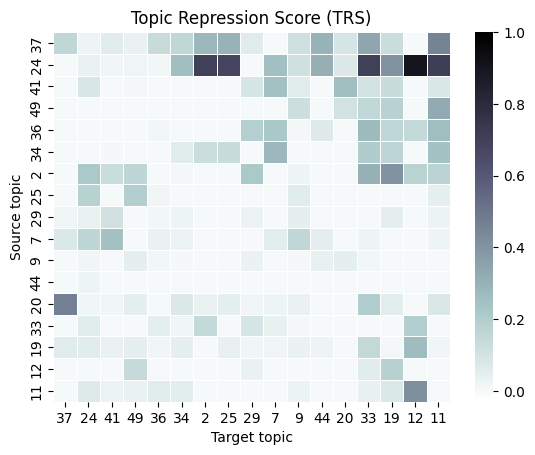

In [9]:
f=sns.heatmap(TRS,cmap=sns.color_palette("bone_r", as_cmap=True),linewidths=0.5,vmin=-0.03,vmax=1)
f.set(xlabel='Target topic', ylabel='Source topic', title="Topic Repression Score (TRS)")

In [10]:
#Get TFs enforcing each topic's repression.
tf_TRS = get_tf_topic_regulation(tf_tr_rep_links, topics, scale_by_topic=True)
tf_TRS #Dataframe showing the repressive effect of TFs in each source topic (rows) towards TRs of alternate topics (columns)


,Source_topic,37,24,41,49,36,34,2,25,29,7,9,44,20,33,19,12,11,Total_effect
NR3C2,37,0.0,0.0,0.0,0.0,1.0,0.918819,0.505469,0.918819,0.0,0.0,0.159226,0.862133,0.0,0.950101,0.0,0.0,0.0,5.314568
TET3,37,0.0,0.0,0.451982,0.0,0.0,0.079683,0.0,0.0,0.330632,0.0,0.644372,0.862133,0.0,0.950101,0.0,0.0,0.0,3.318903
ST18,37,1.0,0.187067,0.0,0.196862,0.9788,0.0,0.0,0.0,0.0,0.0,0.51616,0.0,0.0,0.0,0.0,0.0,0.0,2.878888
MYT1L,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.70104,0.0,0.0,0.313294,2.014334
POU2F2,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800966,0.0,0.515909,0.0,0.313295,1.630169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAF,11,0.0,0.0,0.0,0.0,0.265565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472633,0.0,0.738199
FOSL2,11,0.0,0.0,0.0,0.0,0.265565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472633,0.0,0.738199
MEF2A,11,0.0,0.0,0.0,0.0,0.723001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.723001
IRF1,11,0.0,0.199244,0.0,0.0,0.0,0.439607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.638852


## Net topic regulation potential

In [11]:
#Compute Topic Activation Potential (TAP) between every pair of topics (without significance)
TAP_nosig, _ , background_TAP = compute_topic_regulation_potential(topics, activity, gex, acc, regulons_act, genes, low_exp_TFs=low_exp_TFs, regulation="activation", compute_significance=False)
TAP_nosig, col_scaling_vals = scale_topic_regulation_target_topic(TAP_nosig, scaling = "posCtrl", specificCtrl=[(37,TAP_nosig[37].loc[24])], return_scaling_vals = True)

#Compute Topic Repression Score (TRS) between every pair of topics (without significance)
TRS_nosig, _ , background_TRS = compute_topic_regulation_potential(topics, activity, gex, acc, regulons_rep, genes, low_exp_TFs=low_exp_TFs,regulation="repression",compute_significance=False)
TRS_nosig = scale_topic_regulation_target_topic(TRS_nosig, specificCtrl=col_scaling_vals, return_scaling_vals = False)

#Get net effect of activating and repressive interactions between topics
net_topic_transition_potential = get_net_regulatory_interactions(TAP_nosig, TRS_nosig, topics, background_TAP, background_TRS, get_significant_links=False, percentile=90)


100%|██████████| 17/17 [00:00<00:00, 17.27it/s]


[Text(0.5, 23.52222222222222, 'End topic'),
 Text(50.722222222222214, 0.5, 'Start topic'),
 Text(0.5, 1.0, 'TAP-TRS')]

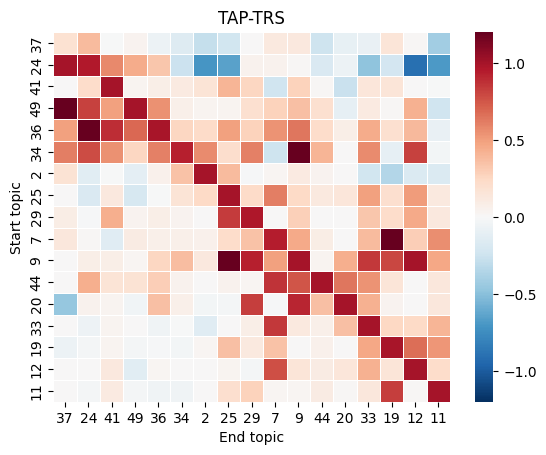

In [12]:
#Plot net topic transition potential
f=sns.heatmap(net_topic_transition_potential,cmap=sns.color_palette("RdBu_r", as_cmap=True),linewidths=0.5,vmin=-1.2,vmax=1.2)
f.set(xlabel='End topic', ylabel='Start topic',title='TAP-TRS')


## State-level regulation 

In [13]:
#Load average topic activity per state
topic_activity_per_state=pd.read_csv("/home/l495i/OE0533_projects/gbm_human/GBM_multiome/mean_topics_activation_coarse_states.tsv",sep="\t")
topic_activity_per_state.index=topic_activity_per_state["annotation_plot"]
del topic_activity_per_state["annotation_plot"]

#Compute state activation and repression potentials
state_activation_potential, col_scaling_vals = compute_state_level_regulation(TAP_nosig, topic_activity_per_state, topics, scale_by_state=True, act_thresh=2/3, return_scaling_vals=True)
state_repression_potential = compute_state_level_regulation(TRS_nosig, topic_activity_per_state, topics, act_thresh=2/3, scale_by_val=col_scaling_vals)


/omics/odcf/analysis/OE0533_projects/gbm_human/GBM_multiome/polished_code/topic_regulation.py:643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_activity_per_state[t][topic_activity_per_state[t]<thresh[t][0]]=0
/omics/odcf/analysis/OE0533_projects/gbm_human/GBM_multiome/polished_code/topic_regulation.py:643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_activity_per_state[t][topic_activity_per_state[t]<thresh[t][0]]=0


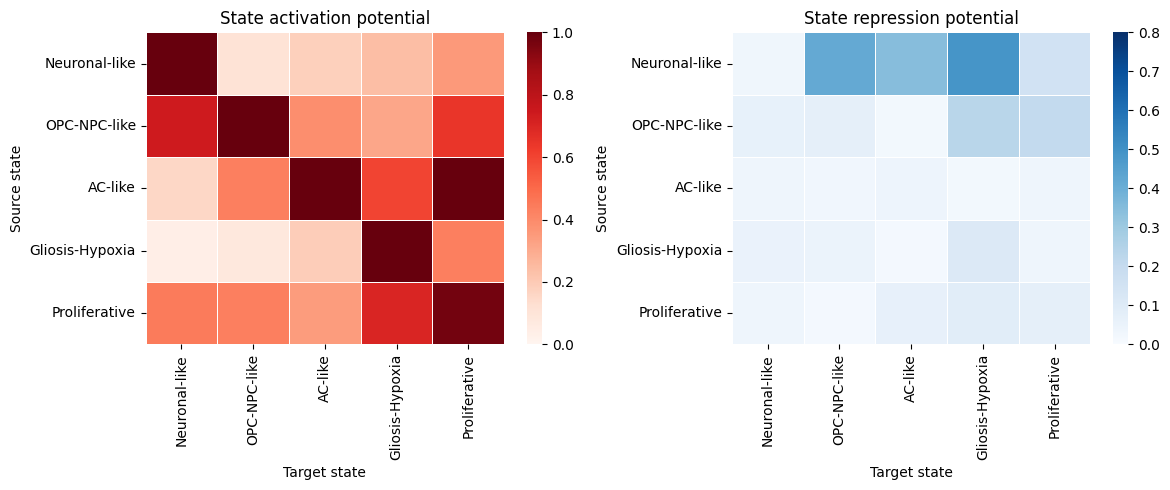

In [14]:
#Plot state activation and repression potential
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(state_activation_potential,ax=axes[0],cmap=sns.color_palette("Reds", as_cmap=True),linewidths=0.5,vmin=0,vmax=1)
axes[0].set_title("State activation potential")
axes[0].set_xlabel("Target state")
axes[0].set_ylabel("Source state")

sns.heatmap(state_repression_potential,ax=axes[1],cmap=sns.color_palette("Blues", as_cmap=True),linewidths=0.5,vmin=0,vmax=0.8)
axes[1].set_title("State repression potential")
axes[1].set_xlabel("Target state")
axes[1].set_ylabel("Source state")

plt.tight_layout()
plt.show()

### Net state transition potential

In [15]:
#Compute net state transition potential
#Get state activation and repression potential without scaling for target state.
state_activation_potential_unscaled = compute_state_level_regulation(TAP_nosig, topic_activity_per_state, topics, scale_by_state=False, act_thresh=2/3)
state_repression_potential_unscaled = compute_state_level_regulation(TRS_nosig, topic_activity_per_state, topics, scale_by_state=False, act_thresh=2/3)

#Get difference between state activation and repression for every state pair
state_transition_potential = state_activation_potential_unscaled-state_repression_potential_unscaled

#Scale net regulation by target state.
state_transition_potential = state_transition_potential/state_transition_potential.max()


/omics/odcf/analysis/OE0533_projects/gbm_human/GBM_multiome/polished_code/topic_regulation.py:643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_activity_per_state[t][topic_activity_per_state[t]<thresh[t][0]]=0
/omics/odcf/analysis/OE0533_projects/gbm_human/GBM_multiome/polished_code/topic_regulation.py:643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_activity_per_state[t][topic_activity_per_state[t]<thresh[t][0]]=0


[Text(0.5, 23.52222222222222, 'Target state'),
 Text(50.72222222222221, 0.5, 'Source state'),
 Text(0.5, 1.0, 'Net state transition potential')]

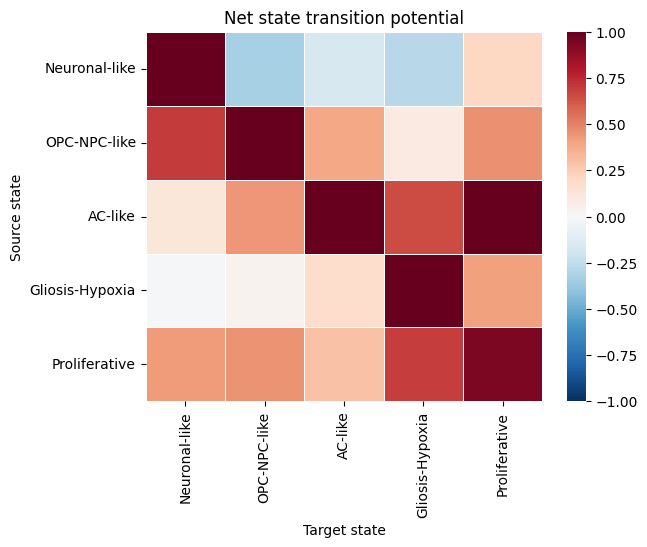

In [16]:
#Plot net state transition potential
f=sns.heatmap(state_transition_potential,cmap=sns.color_palette("RdBu_r", as_cmap=True),linewidths=0.5,vmin=-1,vmax=1)
f.set(xlabel='Target state', ylabel='Source state',title="Net state transition potential")
